<a href="https://colab.research.google.com/github/duydaomanhfake/ML_K3N2_Nhom8/blob/main/BTL_nh%C3%B3m_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')

In [ ]:
# Nối dataset từ drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')

# Đọc dữ liệu
df = pd.read_csv('loan_data.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [ ]:
# Định nghĩa các cột danh mục và số trước khi phân tích
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership',
                    'loan_intent', 'previous_loan_defaults_on_file']
numerical_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
                 'credit_score']

## Phân tích dữ liệu (Data Exploration)

In [ ]:
# 1. Thông tin cơ bản
print("### Thông tin cơ bản về dataset ###")
print("Kích thước dataset:", df.shape)
print("\nThông tin cột:")
print(df.info())
print("\nSố lượng giá trị thiếu:")
print(df.isnull().sum())
print("\nThống kê mô tả các cột số:")
print(df[numerical_cols].describe())

### Thông tin cơ bản về dataset ###
Kích thước dataset: (45000, 14)

Thông tin cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_sc


### Phân phối lớp (loan_status) ###
loan_status
0    35000
1    10000
Name: count, dtype: int64
Tỷ lệ lớp 0: 0.7777777777777778
Tỷ lệ lớp 1: 0.2222222222222222


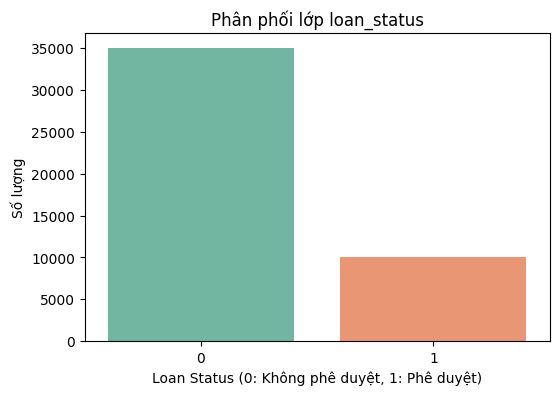

In [ ]:
# 2. Phân tích phân phối lớp (loan_status)
print("\n### Phân phối lớp (loan_status) ###")
class_counts = df['loan_status'].value_counts()
print(class_counts)
print("Tỷ lệ lớp 0:", class_counts[0] / len(df))
print("Tỷ lệ lớp 1:", class_counts[1] / len(df))

# Vẽ biểu đồ phân phối lớp
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df, palette='Set2')
plt.title('Phân phối lớp loan_status')
plt.xlabel('Loan Status (0: Không phê duyệt, 1: Phê duyệt)')
plt.ylabel('Số lượng')
plt.show()


### Phân tích giá trị bất thường ###


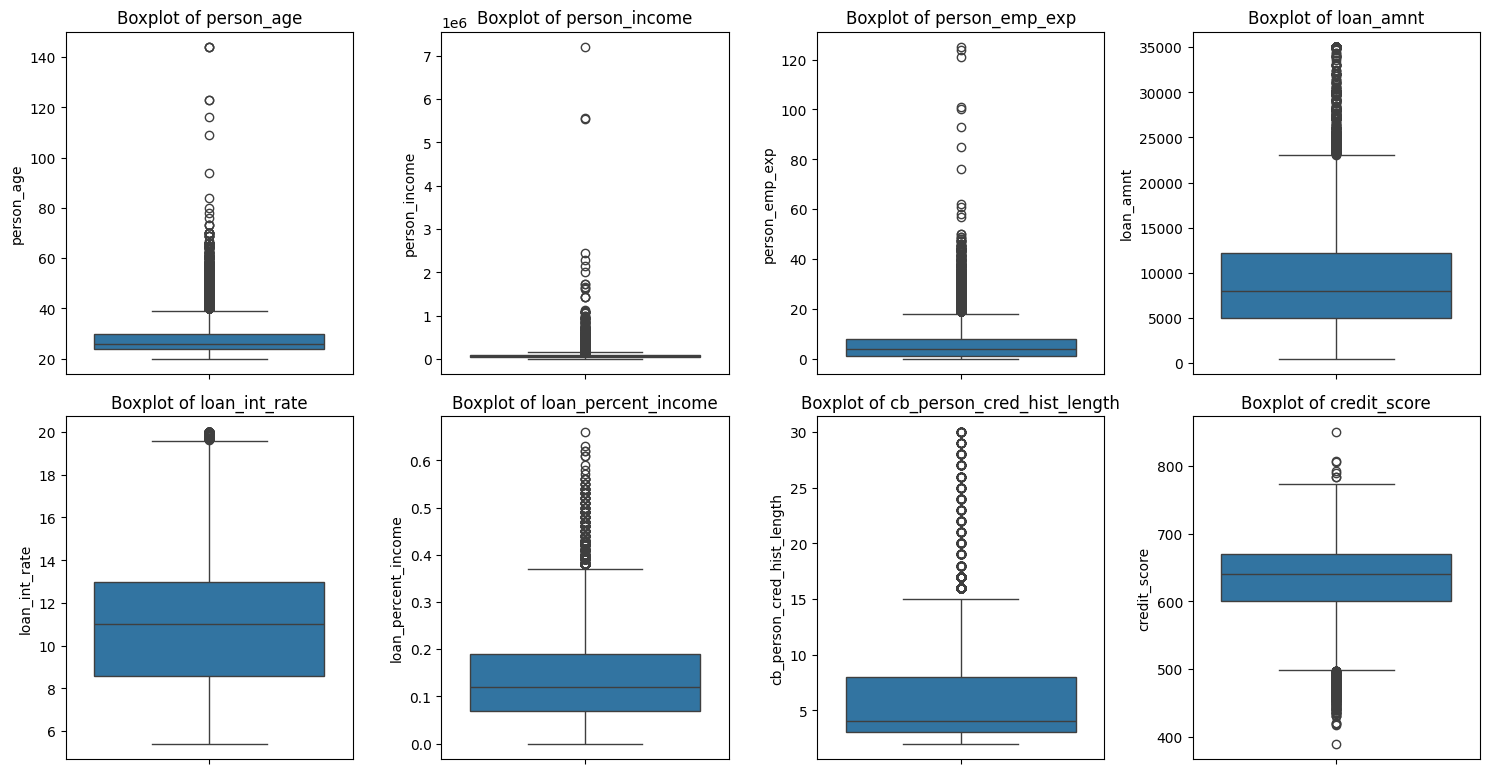

In [ ]:
# 3. Phân tích giá trị bất thường (các cột số)
print("\n### Phân tích giá trị bất thường ###")
# Boxplot cho các cột số
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


### Tương quan giữa các đặc trưng số và loan_status ###
loan_status                   1.000000
loan_percent_income           0.384880
loan_int_rate                 0.332005
loan_amnt                     0.107714
credit_score                 -0.007647
cb_person_cred_hist_length   -0.014851
person_emp_exp               -0.020481
person_age                   -0.021476
person_income                -0.135808
Name: loan_status, dtype: float64


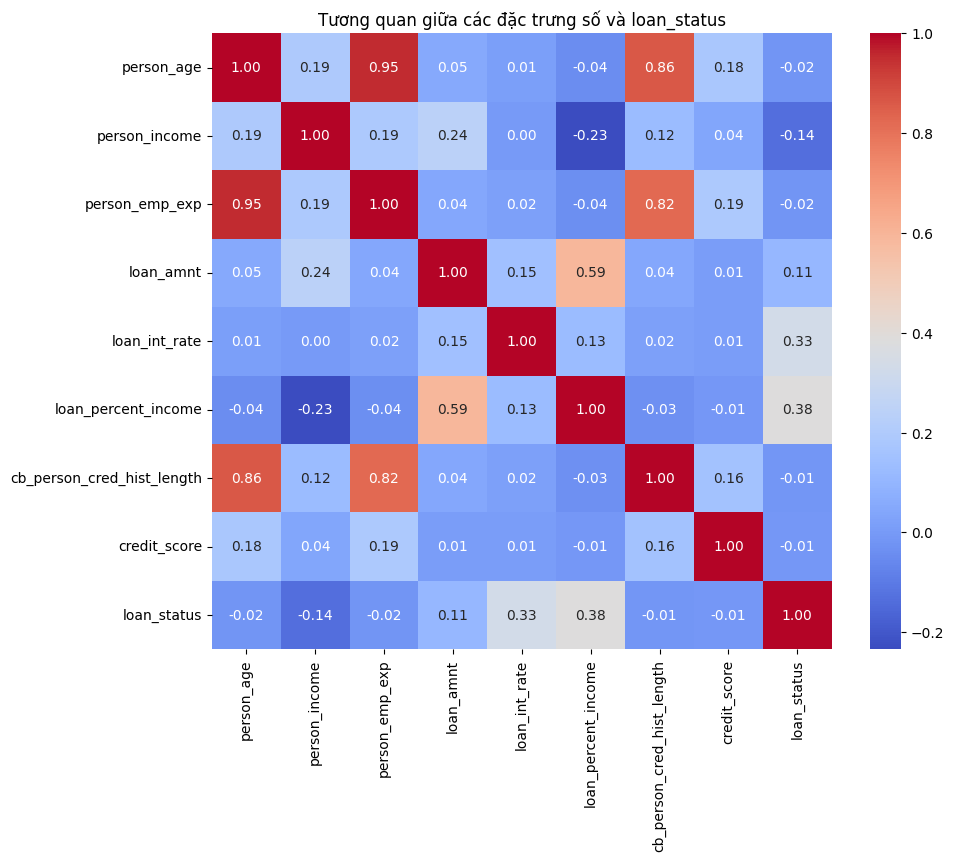

In [ ]:
# 4. Tương quan giữa các đặc trưng số và loan_status
print("\n### Tương quan giữa các đặc trưng số và loan_status ###")
correlation_matrix = df[numerical_cols + ['loan_status']].corr()
print(correlation_matrix['loan_status'].sort_values(ascending=False))

# Heatmap tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Tương quan giữa các đặc trưng số và loan_status')
plt.show()

## Tiền xử lý dữ liệu

In [ ]:
# Làm sạch dữ liệu
df = df[df['person_age'] <= 100]  # Loại bỏ tuổi bất thường
df = df[df['person_income'] <= 5000000]
df = df[df['person_emp_exp'] <= 70]  # Loại bỏ kinh nhiệm làm việc bất thường
df = df[df['person_emp_exp'] <= (df['person_age'] - 16)]  # Loại bỏ kinh nghiệm làm việc không hợp lý

# df = df.dropna()  # Loại bỏ giá trị thiếu  #Do không có giá trị NULL trong tập dữ liệu nên không cần dòng này

# Phân chia đặc trưng và mục tiêu
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Tạo preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])


##Phân chia dữ liệu

In [ ]:
# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##Tăng cường dữ liệu


In [ ]:
# Áp dụng preprocessor trước SMOTE
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Xử lý mất cân bằng lớp bằng SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

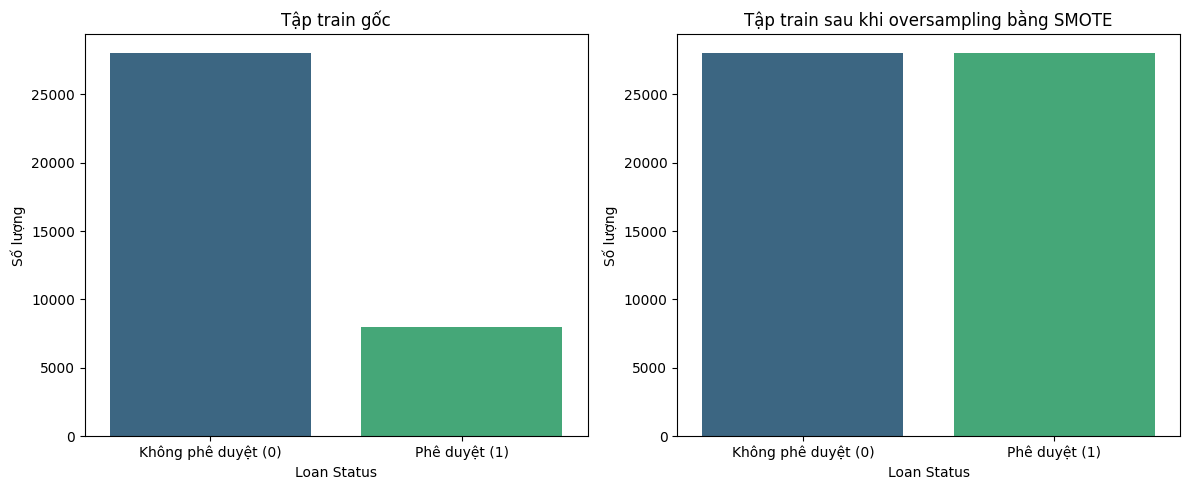

In [ ]:
# So sánh phân phối lớp loan_status ở tập train trước và sau khi oversampling

plt.figure(figsize=(12, 5))

# Biểu đồ phân phối lớp loan_status trong tập train gốc
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='viridis')
plt.title('Tập train gốc')
plt.xlabel('Loan Status')
plt.ylabel('Số lượng')
plt.xticks([0, 1], ['Không phê duyệt (0)', 'Phê duyệt (1)'])

# Biểu đồ phân phối lớp loan_status trong tập train sau khi oversamping bằng SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled, palette='viridis')
plt.title('Tập train sau khi oversampling bằng SMOTE')
plt.xlabel('Loan Status')
plt.ylabel('Số lượng')
plt.xticks([0, 1], ['Không phê duyệt (0)', 'Phê duyệt (1)'])

plt.tight_layout()
plt.show()

##Xây dựng mô hình


In [ ]:
# Định nghĩa các mô hình
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'k-NN': KNeighborsClassifier()
}

# Huấn luyện và đánh giá mô hình
results = {}
for name, model in models.items():
    # Huấn luyện mô hình trực tiếp trên dữ liệu đã tiền xử lý
    model.fit(X_train_resampled, y_train_resampled)

    # Dự đoán
    y_pred = model.predict(X_test_preprocessed)

    # Đánh giá
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    }

    print(f"\nResults for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")

# Tối ưu hóa Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'),
                              param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_search_lr.fit(X_train_resampled, y_train_resampled)

# Kết quả Logistic Regression tốt nhất
print("\nBest Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best F1-Score:", grid_search_lr.best_score_)

# Tối ưu hóa Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# Kết quả Decision Tree tốt nhất
print("\nBest Decision Tree Parameters:", grid_search_dt.best_params_)
print("Best F1-Score:", grid_search_dt.best_score_)

# Tối ưu hóa k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(),
                               param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_search_knn.fit(X_train_resampled, y_train_resampled)

# Kết quả k-NN tốt nhất
print("\nBest k-NN Parameters:", grid_search_knn.best_params_)
print("Best F1-Score:", grid_search_knn.best_score_)


Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      6999
           1       0.62      0.91      0.74      2000

    accuracy                           0.86      8999
   macro avg       0.80      0.88      0.82      8999
weighted avg       0.89      0.86      0.87      8999

Accuracy: 0.8584

Results for Naive Bayes:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      6999
           1       0.47      0.97      0.63      2000

    accuracy                           0.75      8999
   macro avg       0.73      0.83      0.72      8999
weighted avg       0.87      0.75      0.77      8999

Accuracy: 0.7504

Results for Decision Tree:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6999
           1       0.73      0.79      0.76      2000

    accuracy                           0.89      8999
   mac

## Đánh giá mô hình

In [ ]:
# Phân tích đặc trưng quan trọng (Decision Tree)
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = grid_search_dt.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print("\nFeature Importance (Decision Tree):")
print(feature_importance.sort_values(by='Importance', ascending=False).head(10))


Feature Importance (Decision Tree):
                               Feature  Importance
21  previous_loan_defaults_on_file_Yes    0.500840
4                        loan_int_rate    0.112171
15          person_home_ownership_RENT    0.074167
1                        person_income    0.072517
5                  loan_percent_income    0.053367
7                         credit_score    0.033492
3                            loan_amnt    0.022386
6           cb_person_cred_hist_length    0.022184
0                           person_age    0.020549
2                       person_emp_exp    0.020103


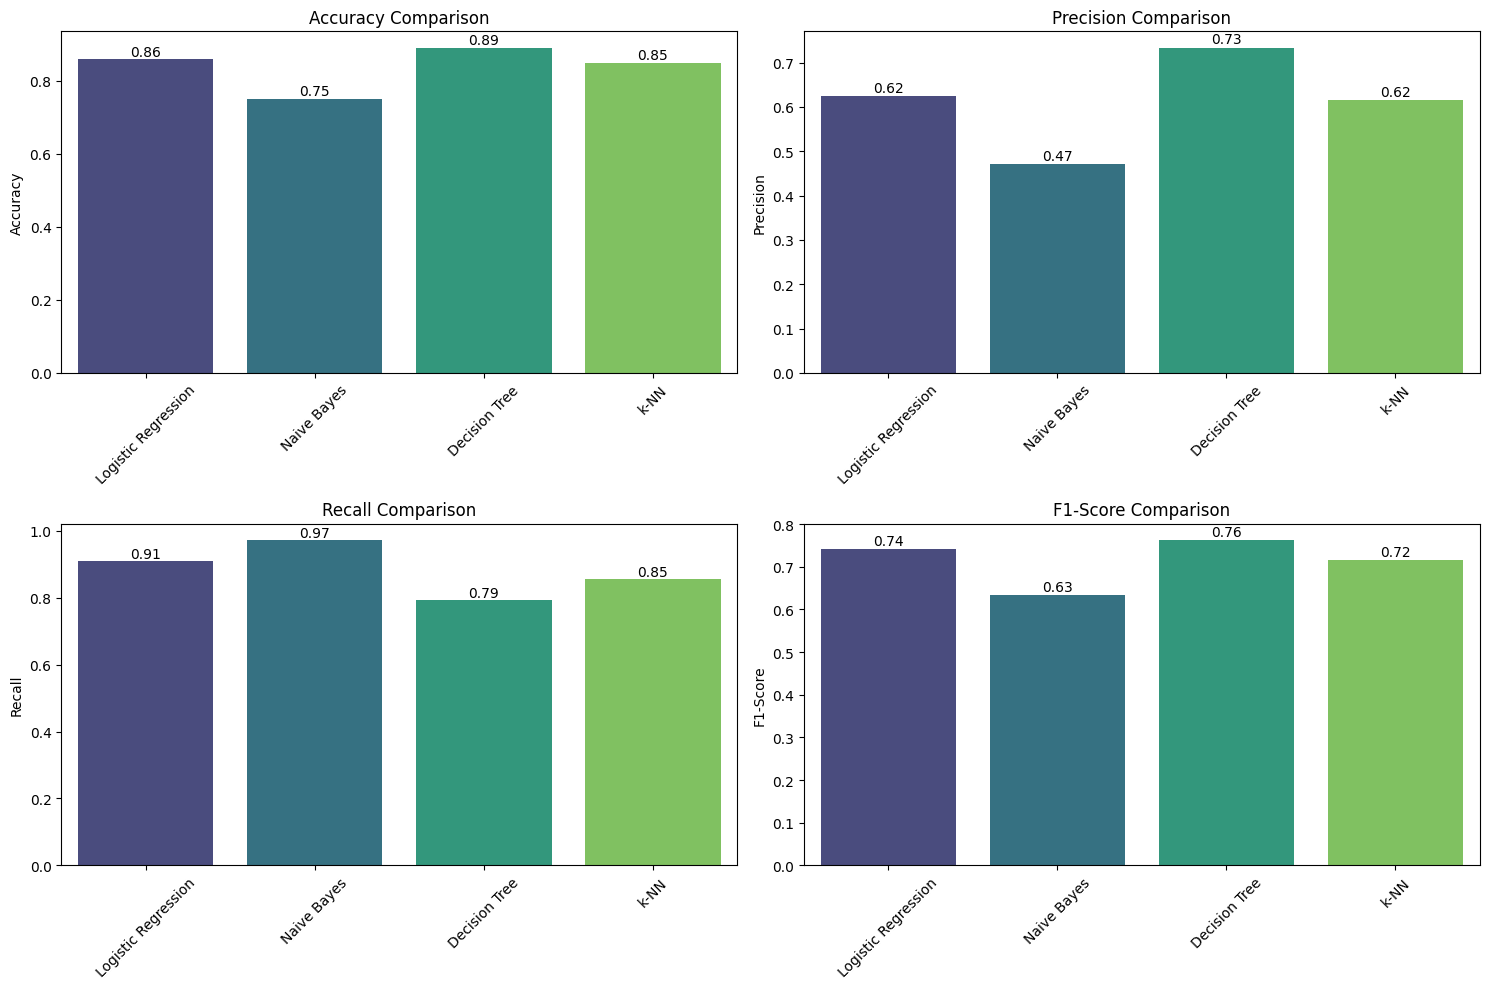

In [ ]:
# Trực quan hóa kết quả
import matplotlib.pyplot as plt
import seaborn as sns

# Kích hoạt hiển thị trực tiếp trong Colab
%matplotlib inline

# 1. Biểu đồ cột so sánh hiệu suất
plt.figure(figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    values = [results[model][metric] for model in models.keys()]
    sns.barplot(x=list(models.keys()), y=values, palette='viridis')
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

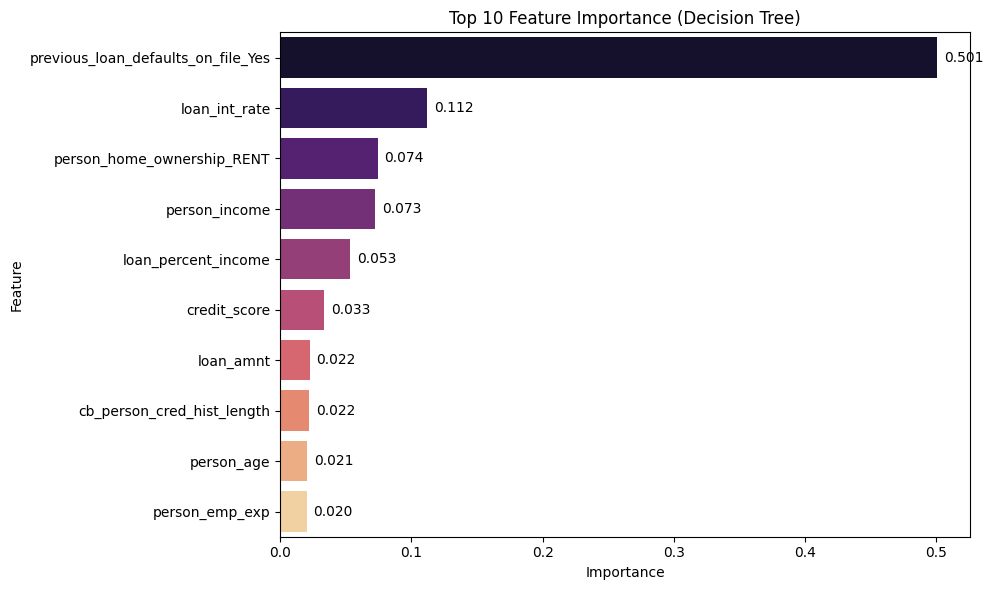

In [ ]:
# 2. Biểu đồ cột tầm quan trọng đặc trưng
plt.figure(figsize=(10, 6))
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)
sns.barplot(x='Importance', y='Feature', data=top_features, palette='magma')
plt.title('Top 10 Feature Importance (Decision Tree)')
plt.xlabel('Importance')
for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.show()

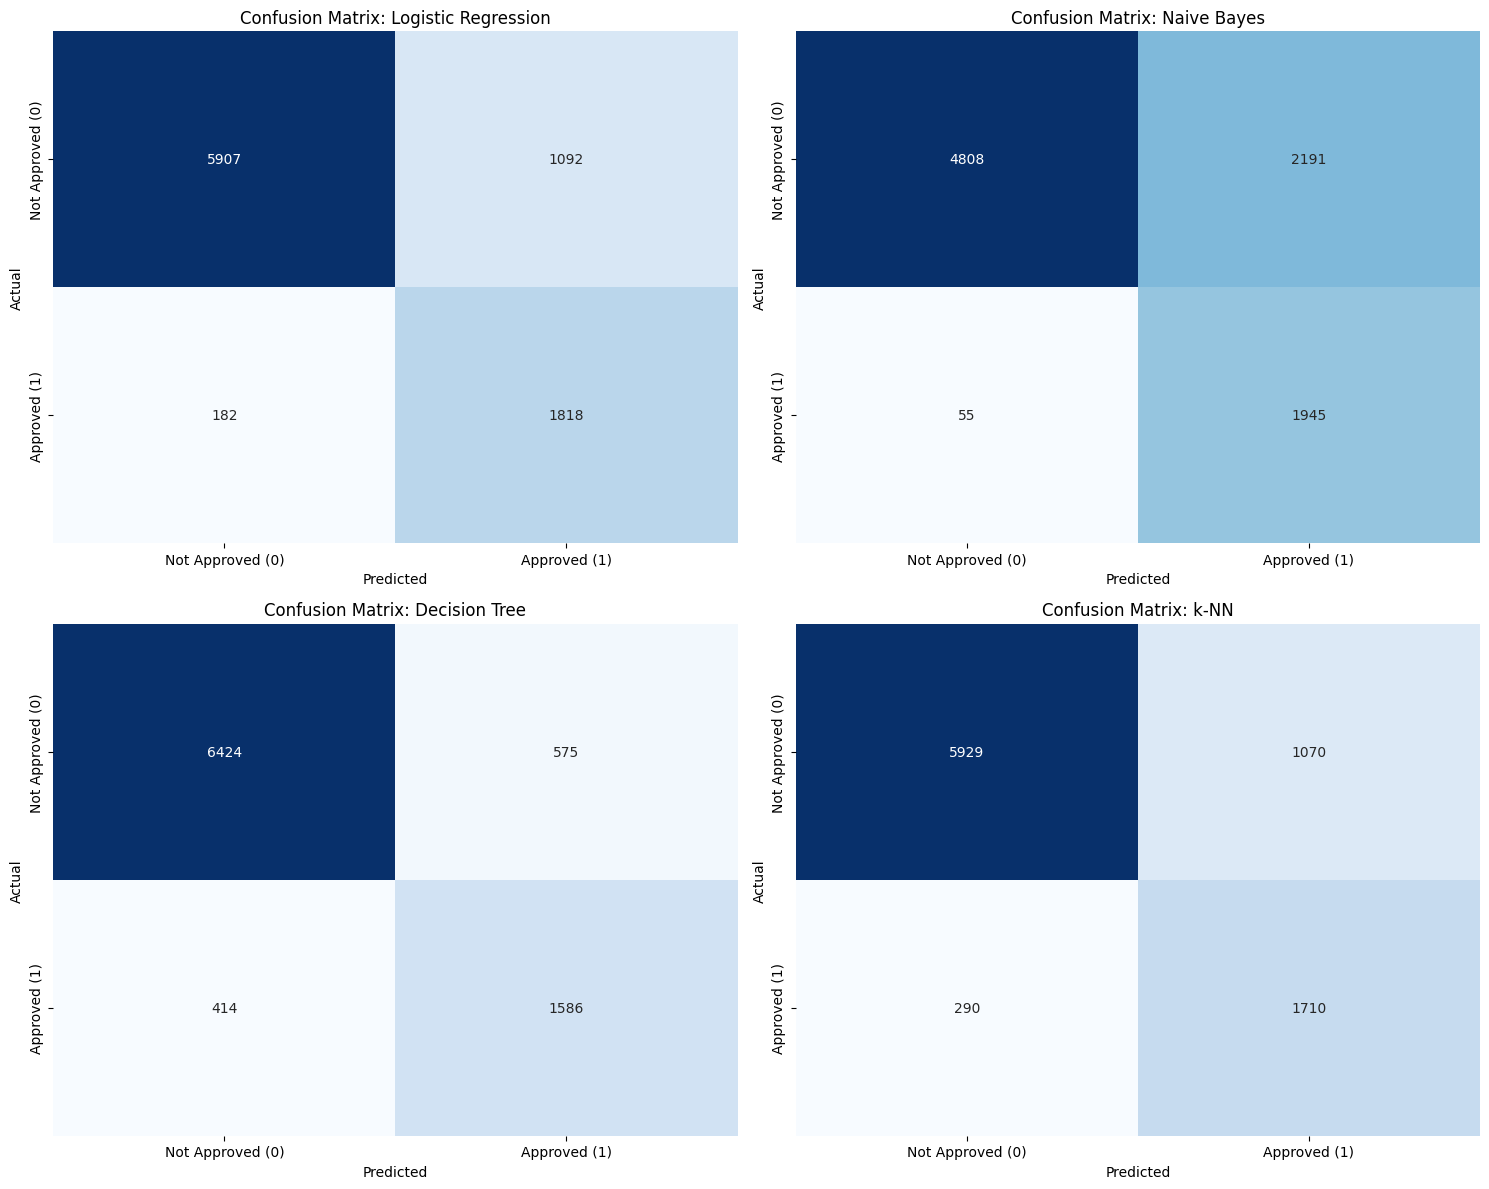

In [ ]:
from sklearn.metrics import confusion_matrix
# 3. Biểu đồ nhiệt ma trận nhầm lẫn
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models.items(), 1):
    # Dự đoán để tạo ma trận nhầm lẫn
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Approved (0)', 'Approved (1)'],
                yticklabels=['Not Approved (0)', 'Approved (1)'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

##Thử nghiệm mô hình

In [ ]:
# Chọn ngẫu nhiên một dòng từ tập test
random_index = np.random.randint(0, len(X_test))

# Lấy dòng dữ liệu và nhãn thực tế tương ứng
random_instance_df = X_test.iloc[[random_index]]
actual_status = y_test.iloc[random_index]

# Tiền xử lý dòng dữ liệu ngẫu nhiên (sử dụng preprocessor)
random_instance_preprocessed = preprocessor.transform(random_instance_df)

print(f"Trường hợp dữ liệu ngẫu nhiên được chọn (index {random_index}):")
display(random_instance_df)
print(f"\nTrạng thái khoản vay thực tế: {'Phê duyệt (1)' if actual_status == 1 else 'Không phê duyệt (0)'}")

# Dự đoán bằng từng mô hình
print("\nDự đoán trạng thái khoản vay cho trường hợp này:")

# Logistic Regression
predicted_status_lr = loaded_lr_model.predict(random_instance_preprocessed)
print(f"Logistic Regression: {'Phê duyệt (1)' if predicted_status_lr[0] == 1 else 'Không phê duyệt (0)'}")

# Naive Bayes
predicted_status_nb = loaded_nb_model.predict(random_instance_preprocessed)
print(f"Naive Bayes: {'Phê duyệt (1)' if predicted_status_nb[0] == 1 else 'Không phê duyệt (0)'}")

# Decision Tree
predicted_status_dt = loaded_dt_model.predict(random_instance_preprocessed)
print(f"Decision Tree: {'Phê duyệt (1)' if predicted_status_dt[0] == 1 else 'Không phê duyệt (0)'}")

# k-NN
predicted_status_knn = loaded_knn_model.predict(random_instance_preprocessed)
print(f"k-NN: {'Phê duyệt (1)' if predicted_status_knn[0] == 1 else 'Không phê duyệt (0)'}")

Trường hợp dữ liệu ngẫu nhiên được chọn (index 3725):


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
18690,34.0,female,Associate,53783.0,10,RENT,16400.0,DEBTCONSOLIDATION,11.03,0.3,10.0,626,No



Trạng thái khoản vay thực tế: Phê duyệt (1)

Dự đoán trạng thái khoản vay cho trường hợp này:
Logistic Regression: Phê duyệt (1)
Naive Bayes: Phê duyệt (1)
Decision Tree: Phê duyệt (1)
k-NN: Phê duyệt (1)


In [ ]:
# Chọn ngẫu nhiên một dòng từ tập test
random_index = np.random.randint(0, len(X_test))

# Lấy dòng dữ liệu và nhãn thực tế tương ứng
random_instance_df = X_test.iloc[[random_index]]
actual_status = y_test.iloc[random_index]

# Tiền xử lý dòng dữ liệu ngẫu nhiên (sử dụng preprocessor)
random_instance_preprocessed = preprocessor.transform(random_instance_df)

print(f"Trường hợp dữ liệu ngẫu nhiên được chọn (index {random_index}):")
display(random_instance_df)
print(f"\nTrạng thái khoản vay thực tế: {'Phê duyệt (1)' if actual_status == 1 else 'Không phê duyệt (0)'}")

# Dự đoán bằng từng mô hình
print("\nDự đoán trạng thái khoản vay cho trường hợp này:")

# Logistic Regression
predicted_status_lr = loaded_lr_model.predict(random_instance_preprocessed)
print(f"Logistic Regression: {'Phê duyệt (1)' if predicted_status_lr[0] == 1 else 'Không phê duyệt (0)'}")

# Naive Bayes
predicted_status_nb = loaded_nb_model.predict(random_instance_preprocessed)
print(f"Naive Bayes: {'Phê duyệt (1)' if predicted_status_nb[0] == 1 else 'Không phê duyệt (0)'}")

# Decision Tree
predicted_status_dt = loaded_dt_model.predict(random_instance_preprocessed)
print(f"Decision Tree: {'Phê duyệt (1)' if predicted_status_dt[0] == 1 else 'Không phê duyệt (0)'}")

# k-NN
predicted_status_knn = loaded_knn_model.predict(random_instance_preprocessed)
print(f"k-NN: {'Phê duyệt (1)' if predicted_status_knn[0] == 1 else 'Không phê duyệt (0)'}")

Trường hợp dữ liệu ngẫu nhiên được chọn (index 474):


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
15116,25.0,male,High School,147434.0,1,MORTGAGE,20000.0,PERSONAL,13.23,0.14,4.0,605,No



Trạng thái khoản vay thực tế: Không phê duyệt (0)

Dự đoán trạng thái khoản vay cho trường hợp này:
Logistic Regression: Phê duyệt (1)
Naive Bayes: Phê duyệt (1)
Decision Tree: Không phê duyệt (0)
k-NN: Không phê duyệt (0)


In [ ]:
# Chọn ngẫu nhiên một dòng từ tập test
random_index = np.random.randint(0, len(X_test))

# Lấy dòng dữ liệu và nhãn thực tế tương ứng
random_instance_df = X_test.iloc[[random_index]]
actual_status = y_test.iloc[random_index]

# Tiền xử lý dòng dữ liệu ngẫu nhiên (sử dụng preprocessor)
random_instance_preprocessed = preprocessor.transform(random_instance_df)

print(f"Trường hợp dữ liệu ngẫu nhiên được chọn (index {random_index}):")
display(random_instance_df)
print(f"\nTrạng thái khoản vay thực tế: {'Phê duyệt (1)' if actual_status == 1 else 'Không phê duyệt (0)'}")

# Dự đoán bằng từng mô hình
print("\nDự đoán trạng thái khoản vay cho trường hợp này:")

# Logistic Regression
predicted_status_lr = loaded_lr_model.predict(random_instance_preprocessed)
print(f"Logistic Regression: {'Phê duyệt (1)' if predicted_status_lr[0] == 1 else 'Không phê duyệt (0)'}")

# Naive Bayes
predicted_status_nb = loaded_nb_model.predict(random_instance_preprocessed)
print(f"Naive Bayes: {'Phê duyệt (1)' if predicted_status_nb[0] == 1 else 'Không phê duyệt (0)'}")

# Decision Tree
predicted_status_dt = loaded_dt_model.predict(random_instance_preprocessed)
print(f"Decision Tree: {'Phê duyệt (1)' if predicted_status_dt[0] == 1 else 'Không phê duyệt (0)'}")

# k-NN
predicted_status_knn = loaded_knn_model.predict(random_instance_preprocessed)
print(f"k-NN: {'Phê duyệt (1)' if predicted_status_knn[0] == 1 else 'Không phê duyệt (0)'}")

Trường hợp dữ liệu ngẫu nhiên được chọn (index 5422):


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
3344,23.0,male,Bachelor,44405.0,2,OWN,15000.0,VENTURE,11.36,0.34,4.0,694,No



Trạng thái khoản vay thực tế: Không phê duyệt (0)

Dự đoán trạng thái khoản vay cho trường hợp này:
Logistic Regression: Phê duyệt (1)
Naive Bayes: Không phê duyệt (0)
Decision Tree: Không phê duyệt (0)
k-NN: Không phê duyệt (0)


#Lưu mô hình vào drive (cái này chắc không cần đưa vào word đâu)

In [ ]:
# Tạo thư mục để lưu mô hình
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)

# Lưu các mô hình vào Drive
joblib.dump(grid_search_lr.best_estimator_, os.path.join(save_dir, 'best_logistic_regression_model.pkl'))
joblib.dump(models['Naive Bayes'], os.path.join(save_dir, 'naive_bayes_model.pkl'))
joblib.dump(grid_search_dt.best_estimator_, os.path.join(save_dir, 'best_decision_tree_model.pkl'))
joblib.dump(grid_search_knn.best_estimator_, os.path.join(save_dir, 'best_knn_model.pkl'))

print(f"Các mô hình tốt nhất đã được lưu vào thư mục: {save_dir}")
print("- best_logistic_regression_model.pkl")
print("- best_decision_tree_model.pkl")
print("- best_knn_model.pkl")
print("- naive_bayes_model.pkl")

Các mô hình tốt nhất đã được lưu vào thư mục: /content/drive/MyDrive/saved_models
- best_logistic_regression_model.pkl
- best_decision_tree_model.pkl
- best_knn_model.pkl
- naive_bayes_model.pkl


In [ ]:
# Tải lại 4 mô hình
os.chdir('/content/drive/MyDrive/saved_models')

loaded_lr_model = joblib.load('best_logistic_regression_model.pkl')
loaded_nb_model = joblib.load('naive_bayes_model.pkl')
loaded_dt_model = joblib.load('best_decision_tree_model.pkl')
loaded_knn_model = joblib.load('best_knn_model.pkl')

print("Đã tải các mô hình:")
print("- Logistic Regression")
print("- Naive Bayes")
print("- Decision Tree")
print("- k-NN")

Đã tải các mô hình:
- Logistic Regression
- Naive Bayes
- Decision Tree
- k-NN
